In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df = pd.read_csv('zillow_data.csv')
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,329121.0,334059.0,338019.0,346657.0,354457.0,361917.0,369769.0,376112.0,381673.0,386586.0,394154.0,402687.0,412006.0,420541.0,429242.0,436291.0,442139.0,447655.0,452725.0,457455.0,461020.0,465658.0,469811.0,475268.0,478912.0,482464.0,484481.0,488259.0,493127.0,499165.0,503717.0,507932.0,511068.0,514280.0,518252.0,522487.0,527352.0,531284.0,535317.0,539349.0,549450.0,567133.0,588505.0,605851.0,613242.0,617110.0,619549.0,625388.0,631255.0,636089.0,639742.0,643306.0,647193.0,652314.0,659961.0,669842.0,683972.0,696806.0,708743.0,716797.0,728843.0,739511.0,759399.0,771571.0,785979.0,795559.0,805064.0,814587.0,817033.0,832764.0,850933.0,876511.0,901911.0,921178.0,927869.0,922251.0,924475.0,931610.0,934145.0,909286.0,874103.0,840213.0,841253.0,864029.0,878088.0,880955.0,875206.0,881249.0,884836.0,877242.0,872894.0,865069.0,888219.0,909058.0,932691.0,932638.0,933780.0,929386.0,935242.0,949011.0,950769.0,940471.0,901618.0,887671.0,894583.0,898397.0,891086.0,854973.0,823871.0,7

In [4]:
df = df.rename(columns={'RegionName': 'Zipcode'})

In [5]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'Zipcode', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [6]:
df_11216 = melt_data(df[df['Zipcode'] == 11216])

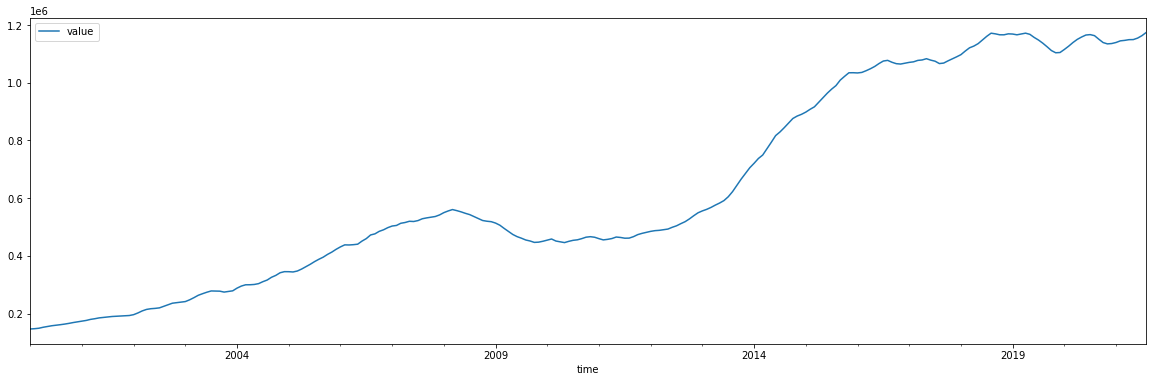

In [7]:
df_11216.plot(figsize=(20,6));

# Baseline Model

In [8]:
naive = df_11216.shift(1)
naive
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(df_11216[1:], naive.dropna()))

7790.716437284674

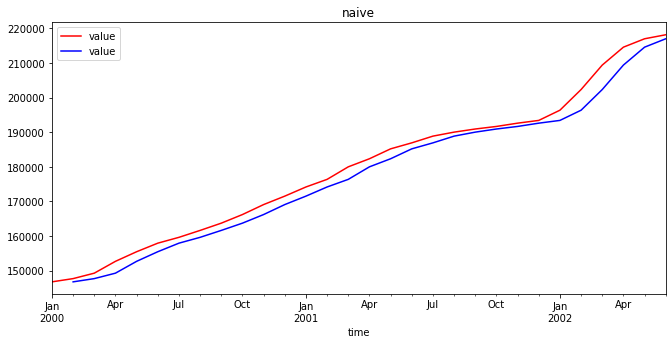

In [9]:
fig, ax = plt.subplots(figsize=(11, 5))

df_11216[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [10]:
dftest = adfuller(naive.dropna())
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.558414
p-value                          0.880105
#Lags Used                      14.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


# Modeling

In [11]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

dftest = adfuller(df_11216)

dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
)

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

Test Statistic                  -0.438568
p-value                          0.903457
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64

The test shows the p-value is higher than 0.5 which means we fail to reject the null hypothesis and the model is non-stationary

## Seasonality

Checking for trends, seasonality, and residuals 

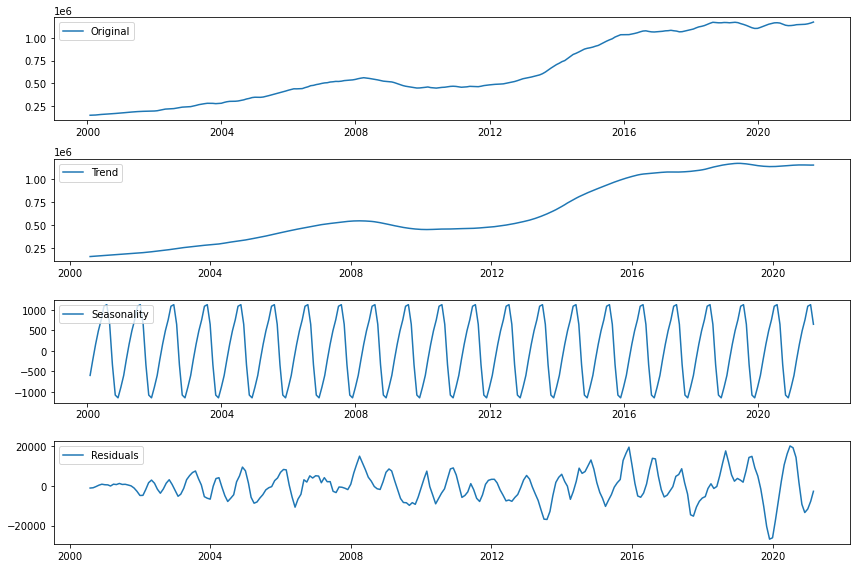

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df_11216)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_11216, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

This dataframe contains seasonality and an upward trend

## Differencing

The difference is taken to make the model stationary

In [13]:
diff = df_11216.diff().diff().dropna()

dftest = adfuller(diff)
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -5.283085
p-value                          0.000006
#Lags Used                      12.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


The p-value is under 0.05, removing the seasonality of the trend

## Autocorrelation

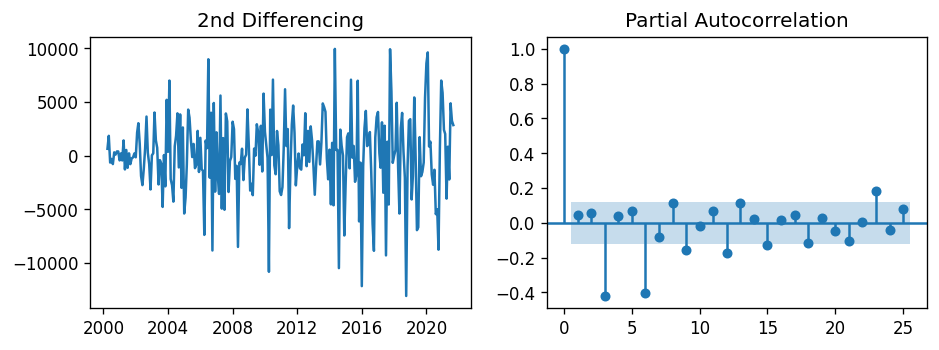

In [14]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_11216.diff().diff().dropna()); axes[0].set_title('2nd Differencing')
plot_pacf(df_11216.diff().diff().dropna(), ax=axes[1])

plt.show()

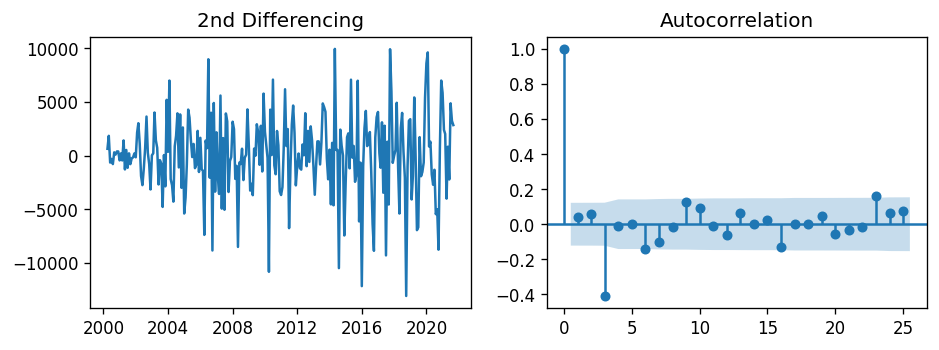

In [15]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_11216.diff().diff().dropna()); axes[0].set_title('2nd Differencing')
plot_acf(df_11216.diff().diff().dropna(), ax=axes[1])

plt.show()

After the second differencing, the data is now stationary as the lags are within the boundaries

## SARIMAX Model

In [16]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [17]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_11216,
                         order=comb,
                         seasonal_order=combs,
                         enforce_stationarity=False,
                         enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmo

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7723.409285982818
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7219.242348276498
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =6864.101698928532
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6269.367878147872


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5896.005150690537


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =5574.522913462238


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =5836.806733972615


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =5551.138966108563


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =5292.287784538302
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =6216.098569219061


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =6133.4577685685235


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =5830.569883290524
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5826.010440041557


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =7719.789340413646


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =7053.528350370762
ARIMA (0, 0, 0) x (1, 2, 0, 12)12 : AIC Calculated =5573.146316657734


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (1, 2, 1, 12)12 : AIC Calculated =6521.7949151638095


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (1, 2, 2, 12)12 : AIC Calculated =6185.9391440466225
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =5824.083867705698


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =5824.952492219063


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (2, 0, 2, 12)12 : AIC Calculated =5800.7651529154955
ARIMA (0, 0, 0) x (2, 1, 0, 12)12 : AIC Calculated =5541.693895628115


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (2, 1, 1, 12)12 : AIC Calculated =7044.0068454705115


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (0, 0, 0) x (2, 1, 2, 12)12 : AIC Calculated =6999.590014720199
ARIMA (0, 0, 0) x (2, 2, 0, 12)12 : AIC Calculated =5287.504866675448


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (2, 2, 1, 12)12 : AIC Calculated =6170.480423482466


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (0, 0, 0) x (2, 2, 2, 12)12 : AIC Calculated =5872.16143818769
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7505.951240884598


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =7115.5524962161835


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (0, 0, 2, 12)12 : AIC Calculated =6759.6534817250995
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =6072.254808103158


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =5752.376992662218


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (0, 1, 2, 12)12 : AIC Calculated =6917.648329828993


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (0, 2, 0, 12)12 : AIC Calculated =5633.831778156042


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (0, 2, 1, 12)12 : AIC Calculated =6806.933889897062


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (0, 2, 2, 12)12 : AIC Calculated =6011.325975404245
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =7154.893888191513


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =7099.05679264303


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (1, 0, 2, 12)12 : AIC Calculated =6755.070850067998


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =5789.475497030143


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =6144.334698703998


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (1, 1, 2, 12)12 : AIC Calculated =6613.709246177792


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (1, 2, 0, 12)12 : AIC Calculated =5396.817030883563


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (1, 2, 1, 12)12 : AIC Calculated =6358.815690361598


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (1, 2, 2, 12)12 : AIC Calculated =5955.07495183047


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated =6810.728659995563


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated =6812.724763859698


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (2, 0, 2, 12)12 : AIC Calculated =6757.063809194098


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (2, 1, 0, 12)12 : AIC Calculated =5498.626177073511


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (2, 1, 1, 12)12 : AIC Calculated =5500.265871693063


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (2, 1, 2, 12)12 : AIC Calculated =6607.62258729474


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (2, 2, 0, 12)12 : AIC Calculated =5113.032353357976


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (2, 2, 1, 12)12 : AIC Calculated =6066.987779913748


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (2, 2, 2, 12)12 : AIC Calculated =5956.046103978912


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated =7436.417181888875


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated =7413.752977249411


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (0, 0, 2, 12)12 : AIC Calculated =6732.409372855822


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (0, 1, 0, 12)12 : AIC Calculated =6001.318174716085


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated =5698.802505377229


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (0, 0, 2) x (0, 1, 2, 12)12 : AIC Calculated =6865.259537644167
ARIMA (0, 0, 2) x (0, 2, 0, 12)12 : AIC Calculated =5543.341833710819


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (0, 2, 1, 12)12 : AIC Calculated =7315.14232757402


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (0, 2, 2, 12)12 : AIC Calculated =6062.145971791582


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated =7160.148068063218


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated =7075.602478858917


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (1, 0, 2, 12)12 : AIC Calculated =6731.525080077676


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (1, 1, 0, 12)12 : AIC Calculated =6034.818563991232


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (0, 0, 2) x (1, 1, 1, 12)12 : AIC Calculated =5699.666421227072
ARIMA (0, 0, 2) x (1, 1, 2, 12)12 : AIC Calculated =6569.455963761087


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (1, 2, 0, 12)12 : AIC Calculated =5336.106939759153


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (1, 2, 1, 12)12 : AIC Calculated =6979.528840436214


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (1, 2, 2, 12)12 : AIC Calculated =5895.8952306944975


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (2, 0, 0, 12)12 : AIC Calculated =6982.128855263265


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (0, 0, 2) x (2, 0, 1, 12)12 : AIC Calculated =6818.0100168575755
ARIMA (0, 0, 2) x (2, 0, 2, 12)12 : AIC Calculated =6733.530613905987


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (2, 1, 0, 12)12 : AIC Calculated =5477.363484162808


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (2, 1, 1, 12)12 : AIC Calculated =5479.106970194762


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (2, 1, 2, 12)12 : AIC Calculated =6566.500060731074


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (2, 2, 0, 12)12 : AIC Calculated =5049.441120810551


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (2, 2, 1, 12)12 : AIC Calculated =6135.033385379473


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 2) x (2, 2, 2, 12)12 : AIC Calculated =5895.254526741931
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =5358.878695432173
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =5082.358831014035


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmo

ARIMA (0, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =4828.53430246744
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =5109.952321476352
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4842.645309973801


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmo

ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =4607.214724570209
ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =5106.482240981366


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =4727.3689991173205


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =4487.2102423191445
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =5066.590951473268
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =5046.189221310598


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmo

ARIMA (0, 1, 0) x (1, 0, 2, 12)12 : AIC Calculated =4809.9439317028955
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4856.387781809428


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4838.981725504631


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =4600.427927175817
ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =4736.3659359320445


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =4660.9530488141245


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =4427.509563832669
ARIMA (0, 1, 0) x (2, 0, 0, 12)12 : AIC Calculated =4826.485465085413


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (2, 0, 1, 12)12 : AIC Calculated =4826.950360398032


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =4810.847545414241
ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =4620.277845506889


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =4618.237563049592


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =4599.606785389146
ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =4465.411974610206


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =4431.722985895447


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =4415.590005541931
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =5182.02591856049


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4934.307558988591


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =4655.85438333898
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4975.456030059848


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4708.286688404507


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =4465.374497051359
ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4976.366095320784


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =4621.148735591336


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =4355.064453859066
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4972.856617587251


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4929.474514615607


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4692.770824372354


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4748.841849026696


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4707.214836849822


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =4465.762305838498


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4687.350509798655


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =4603.452151442709


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =4356.195023450665


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =4732.073284132346


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =4734.017937938097


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =4694.334852759115


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =4509.993853902048


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =4508.965380110423


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =4466.909148021434


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =4421.743257295879


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =4398.010316431932


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =4359.251788211257
ARIMA (0, 1, 2) x (0, 0, 0, 12)12 : AIC Calculated =5023.806857287952


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (0, 0, 1, 12)12 : AIC Calculated =4790.804322837888


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (0, 0, 2, 12)12 : AIC Calculated =4557.233755150979
ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =4870.091761651341


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =4573.581087114187


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =4301.398017803351


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =4796.837067503369


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =4480.34539877966


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =4230.004174774256


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (1, 0, 0, 12)12 : AIC Calculated =4853.157230929344


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (1, 0, 1, 12)12 : AIC Calculated =4670.977161112205


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (1, 0, 2, 12)12 : AIC Calculated =4559.231962720059


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =4650.498971885672


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =4574.403617722557


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =4300.394400352391


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =4607.630824651445


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =4465.747920544546


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =4226.920676083917


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =4620.274608994168


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =4620.947469625862


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =4561.191584751444


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =4375.951133175755


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =4370.6559754613045


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =4302.196816764706


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =4314.426725398725


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =4287.235805629214


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =4226.288240065395
ARIMA (0, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =4953.021982668835
ARIMA (0, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =4734.632046564238


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmo

ARIMA (0, 2, 0) x (0, 0, 2, 12)12 : AIC Calculated =4515.970064735266
ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4910.915396302429


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =4608.95635799185


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =4350.910513928741
ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4943.804175494343


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =4527.420926358169


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =4255.737924914049
ARIMA (0, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =4752.387579135955


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =4735.869756082483


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =4513.465835256984
ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =4609.440430895604


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =4590.71851332531


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =4342.241892209478
ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =4545.878071420711


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =4437.975379200825


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =4182.000065272103
ARIMA (0, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =4532.217534124348


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =4530.169305630055


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (2, 0, 2, 12)12 : AIC Calculated =4513.0549966300305
ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =4372.327734091676


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =4361.941730108377


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =4344.44895155301


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =4269.0250591124


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =4209.610317318832


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =4189.477951239273
ARIMA (0, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =4936.0937503639525


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =4717.132167642528


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (0, 0, 2, 12)12 : AIC Calculated =4498.379850816078
ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =4893.2208248393235


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =4598.663102810639


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =4340.295355018742
ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4924.4372499616775


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =4551.883471842863


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =4275.830004146623
ARIMA (0, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =4754.081086811115


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =4718.213002067903


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated =4494.798189888754


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =4624.516832737399


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =4586.137303565924


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =4342.250006919289


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =4547.108089999629


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =4523.4911687981685


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =4273.563381972163


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =4534.604361965769


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =4531.8837624761145


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (2, 0, 2, 12)12 : AIC Calculated =4494.156255447879


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =4387.074792220255


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =4381.110717413088


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =4344.207776524141


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =4336.641555057492


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =4316.120445412558


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =4278.270231412942
ARIMA (0, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated =4913.781957371077


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated =4686.508538809749


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =4465.853689149146
ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4876.154045292556


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =4581.97804389417


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =4323.627711506024


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4905.50133647164


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =4535.035006524342


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =4259.201493534536
ARIMA (0, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4743.5902519913


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4686.646082078942


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =4465.438681988333


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4627.304970853038


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =4553.76021175067


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =4325.530204042522


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4601.165157369708


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =4506.674784500378


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =4256.905303244655


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =4522.77944901131


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =4523.0080352215155


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =4467.0536225731175


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =4389.1494869481485


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =4363.441428324857


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =4327.513998410623


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =4339.991591952214


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =4201.403687495444


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =4134.190775238606
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =5317.8667670063105


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =5199.736089000875


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =4912.08105827515
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5130.691662678093


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmo

ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4896.022232896681


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4617.596810386288
ARIMA (1, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =5125.124847667323


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4885.112762276746


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =4517.503462223199


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5050.3190960089505


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5051.848824365322


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =4897.254495700376


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4859.408205372825


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4861.4062240964195


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =4620.142033611863


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 2, 0, 12)12 : AIC Calculated =4768.070005388301


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 2, 1, 12)12 : AIC Calculated =5589.681473834493


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 2, 2, 12)12 : AIC Calculated =5000.394698324761


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =4816.314042619953


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =4939.877986096464


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (2, 0, 2, 12)12 : AIC Calculated =4814.577118846355


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (2, 1, 0, 12)12 : AIC Calculated =4622.368092560111


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (2, 1, 1, 12)12 : AIC Calculated =5221.246802214334


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 0, 0) x (2, 1, 2, 12)12 : AIC Calculated =5087.466798680097
ARIMA (1, 0, 0) x (2, 2, 0, 12)12 : AIC Calculated =4504.1100211971025


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (2, 2, 1, 12)12 : AIC Calculated =5022.440236215928


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 0) x (2, 2, 2, 12)12 : AIC Calculated =4488.978358714878
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =5144.505251474618


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =5092.744451369346


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (0, 0, 2, 12)12 : AIC Calculated =4817.073233532583
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5013.751192177244


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmo

ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4760.189067600171


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (0, 1, 2, 12)12 : AIC Calculated =5022.982314552801
ARIMA (1, 0, 1) x (0, 2, 0, 12)12 : AIC Calculated =5005.443277320939


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 0, 1) x (0, 2, 1, 12)12 : AIC Calculated =4779.726899932405


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (0, 2, 2, 12)12 : AIC Calculated =4420.542231919274


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4930.589785428864


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =5085.265352922701


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 0, 2, 12)12 : AIC Calculated =4813.469758211404


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =4762.450753870495


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =4938.649790117061
ARIMA (1, 0, 1) x (1, 1, 2, 12)12 : AIC Calculated =4550.935439974008


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 2, 0, 12)12 : AIC Calculated =4695.343206912626


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 2, 1, 12)12 : AIC Calculated =5223.948664549242


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 2, 2, 12)12 : AIC Calculated =4791.376514279078


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated =4694.909525604686


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated =4858.124290846239


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 0, 1) x (2, 0, 2, 12)12 : AIC Calculated =4870.282476554679
ARIMA (1, 0, 1) x (2, 1, 0, 12)12 : AIC Calculated =4511.024519878214


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (2, 1, 1, 12)12 : AIC Calculated =5098.0872274981975


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 0, 1) x (2, 1, 2, 12)12 : AIC Calculated =4489.719534149612
ARIMA (1, 0, 1) x (2, 2, 0, 12)12 : AIC Calculated =4426.094554389675


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (2, 2, 1, 12)12 : AIC Calculated =4402.335006167083


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (2, 2, 2, 12)12 : AIC Calculated =4384.140635770894


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated =4965.5703529018365


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated =4739.770333339919


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 0, 2) x (0, 0, 2, 12)12 : AIC Calculated =4694.191853144535
ARIMA (1, 0, 2) x (0, 1, 0, 12)12 : AIC Calculated =4910.0586595396935


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated =6264.709946820073


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 0, 2) x (0, 1, 2, 12)12 : AIC Calculated =4452.048181122111
ARIMA (1, 0, 2) x (0, 2, 0, 12)12 : AIC Calculated =4906.734269875398


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 0, 2) x (0, 2, 1, 12)12 : AIC Calculated =4636.599908332302
ARIMA (1, 0, 2) x (0, 2, 2, 12)12 : AIC Calculated =4974.298570274523


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated =4780.094171771985


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated =4940.70011803629


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 0, 2) x (1, 0, 2, 12)12 : AIC Calculated =4670.102396664096
ARIMA (1, 0, 2) x (1, 1, 0, 12)12 : AIC Calculated =4662.039383312962


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (1, 1, 1, 12)12 : AIC Calculated =5202.678418182779


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (1, 1, 2, 12)12 : AIC Calculated =4705.685160365336


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (1, 2, 0, 12)12 : AIC Calculated =4635.53497116973


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (1, 2, 1, 12)12 : AIC Calculated =5110.286898123566


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 2) x (1, 2, 2, 12)12 : AIC Calculated =4316.675277656677


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (2, 0, 0, 12)12 : AIC Calculated =4553.383247669867


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (2, 0, 1, 12)12 : AIC Calculated =4735.899146812064


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 0, 2) x (2, 0, 2, 12)12 : AIC Calculated =4670.9905845055655
ARIMA (1, 0, 2) x (2, 1, 0, 12)12 : AIC Calculated =4385.29365643099


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (2, 1, 1, 12)12 : AIC Calculated =4969.727034081956


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (2, 1, 2, 12)12 : AIC Calculated =4500.765547157327


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 2) x (2, 2, 0, 12)12 : AIC Calculated =4340.884422777877


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 2) x (2, 2, 1, 12)12 : AIC Calculated =4342.241236495823


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 2) x (2, 2, 2, 12)12 : AIC Calculated =4281.471778727507
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =4959.472130620405
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =4742.16184977147


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmo

ARIMA (1, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =4522.8252392397735
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4901.627335550924


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4618.368603701222


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =4358.975367097277
ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4930.8775659761195


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =4561.242426402245


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =4288.021390796192
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4742.154282793519


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4743.674875148952


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 0, 2, 12)12 : AIC Calculated =4525.797154743141


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4591.6813545196765


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4602.712790541257


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =4360.975066592879


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =4568.208571161405


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =4530.623287630883


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =4171.038072447604


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (2, 0, 0, 12)12 : AIC Calculated =4522.317347779668


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (2, 0, 1, 12)12 : AIC Calculated =4520.965197370226


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =4520.40375773849


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =4367.089997160797


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =4361.848358466485


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =4362.963567137125


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =4308.573287257048


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =4285.079470529763


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =4285.125676208223
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4941.088984566754


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4723.669723875213


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =4504.913973293187
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4881.804926064979


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4600.789514499334


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =4341.832201010568


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4907.841366858059


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =4540.930817926092


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =4268.780846997612
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4742.167711794242


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4725.217500112755


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4507.179971990083


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4603.997410357442


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4585.776512188035


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =4343.825496297026


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4569.150301881513


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =4511.441429379033


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =4265.110312282783


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =4522.8282284414745


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =4521.370187324581


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =4502.3104635129075


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =4369.074867098027


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =4363.8748554179365


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =4345.8187173164315


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =4309.554456141695


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =4176.237784843285


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =4270.193484737709
ARIMA (1, 1, 2) x (0, 0, 0, 12)12 : AIC Calculated =4907.515143321469


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (0, 0, 1, 12)12 : AIC Calculated =4650.486558150891


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (0, 0, 2, 12)12 : AIC Calculated =4428.723173394624


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =4842.955870916237


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =4548.3155517566765


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =4281.069358713811


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =4858.2292821288565


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =4472.616323027674


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =4215.585158549849


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (1, 0, 0, 12)12 : AIC Calculated =4686.553425642804


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (1, 0, 1, 12)12 : AIC Calculated =4649.177899628252


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (1, 0, 2, 12)12 : AIC Calculated =4430.519281296092


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =4592.51539030818


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =4543.442999124037


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =4280.85733210302


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =4547.820534353616


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =4453.736163404645


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =4213.087117696132


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =4466.118382959772


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =4467.429752720847


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =4432.11002218417


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =4337.168058349934


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =4322.828055968727


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =4282.365504538826


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =4279.303161036876


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =4164.3845110505445


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =4214.01873080358
ARIMA (1, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =4954.539977459015
ARIMA (1, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =4735.481063156156


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmo

ARIMA (1, 2, 0) x (0, 0, 2, 12)12 : AIC Calculated =4517.080908473415
ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4912.58130831702


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =4617.714955026496


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =4358.748831468981
ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4944.711125272484


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =4570.54415513372


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =4294.159966688057
ARIMA (1, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =4735.582298312804


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =4736.4606810407295


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =4513.562044846937


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =4590.629866288693


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =4590.255429926906


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =4360.602554548728


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =4575.923854130644


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =4541.359832745326


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =4291.550452974236
ARIMA (1, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =4516.397780953808


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =4513.47363282788


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (2, 0, 2, 12)12 : AIC Calculated =4512.78512784458


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =4366.742771876266


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =4342.870257316708


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =4362.622848036872


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =4245.614358892234


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =4176.915211611988


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =4296.739201868291


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =4939.012841298988


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =4718.306183150639


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (0, 0, 2, 12)12 : AIC Calculated =4498.634201376976


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =4904.485621510535


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =4581.211126002596


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =4329.637004943206


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4928.433261206639


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =4527.457626502797


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =4246.996669708531


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =4739.082222066656


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =4720.11152808716


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated =4495.800981520571


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =4588.731709864234


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =4573.665755863714


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =4331.757182161171
ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =4549.941371795883


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =4493.088303882807


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =4244.358437396515


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =4516.975005618571


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =4514.682075096558


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (2, 0, 2, 12)12 : AIC Calculated =4497.098271610215


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =4353.5233970998


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =4350.560551509563


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =6065.367198189547


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =4288.231612311472


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =4266.016858028828


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =4244.966419510461
ARIMA (1, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated =4892.475341718421


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated =4645.962864930338


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =4422.695572440907


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4855.760486542224


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =4568.315394531857


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =4305.1256773287305


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4882.842818384098


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =4518.752463863331


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =4254.584687890963


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4684.713310177187


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4644.908414361742


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =4424.69018874941


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4605.572160511166


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =4555.460357805023


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =4301.472051799432


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4580.546277404823


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =4497.63554043986


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =4252.44044247692


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =4459.938158058265


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =4461.929785504328


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =4425.980125916096


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =4353.671522427839


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =4346.763239048818


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =4303.017518665492


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =4315.601459794436


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =4293.0545163961115


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =4255.031022331401
ARIMA (2, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4957.759399861499


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =5083.283474187307


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =4804.884693861104
ARIMA (2, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4899.13743661954


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmo

ARIMA (2, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4698.208966635315
ARIMA (2, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =5094.398894286949


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =4913.722907061188


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4705.057401820763
ARIMA (2, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =4919.204077423769


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4740.6396436192135


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5064.0312969600145


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =4848.85806173257


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4601.139576382935


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4822.470179489975


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =4552.24446006423


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (1, 2, 0, 12)12 : AIC Calculated =4557.52612467847


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (1, 2, 1, 12)12 : AIC Calculated =4518.955382327007


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (1, 2, 2, 12)12 : AIC Calculated =4294.632893826305


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =4521.361855514413


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =4820.462966665367


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 0, 0) x (2, 0, 2, 12)12 : AIC Calculated =4810.569275895431
ARIMA (2, 0, 0) x (2, 1, 0, 12)12 : AIC Calculated =4366.557728722995


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (2, 1, 1, 12)12 : AIC Calculated =4363.104525298033


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 0) x (2, 1, 2, 12)12 : AIC Calculated =4531.020120155905


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (2, 2, 0, 12)12 : AIC Calculated =4298.649153666027


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 0) x (2, 2, 1, 12)12 : AIC Calculated =4317.195483512696


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 0) x (2, 2, 2, 12)12 : AIC Calculated =4279.997111800368


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =4959.4283304421


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =4969.98827563799


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 0, 1) x (0, 0, 2, 12)12 : AIC Calculated =4764.136733973988
ARIMA (2, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4899.983324129587


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =5798.642007352941
ARIMA (2, 0, 1) x (0, 1, 2, 12)12 : AIC Calculated =5047.034687172874


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (0, 2, 0, 12)12 : AIC Calculated =4914.4096217648785


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 0, 1) x (0, 2, 1, 12)12 : AIC Calculated =4695.137249845644


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (0, 2, 2, 12)12 : AIC Calculated =4867.420578998994


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4740.184106678435


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =4869.801554414068


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (1, 0, 2, 12)12 : AIC Calculated =4732.764148607195
ARIMA (2, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =4602.7659231153775


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =4812.883830088951


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (1, 1, 2, 12)12 : AIC Calculated =4508.937063218531


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (1, 2, 0, 12)12 : AIC Calculated =4559.067600120899


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (1, 2, 1, 12)12 : AIC Calculated =4520.28927942731


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (1, 2, 2, 12)12 : AIC Calculated =4276.158173172106


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated =4521.429311598478


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated =4801.701068785267


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 0, 1) x (2, 0, 2, 12)12 : AIC Calculated =4706.486918671918
ARIMA (2, 0, 1) x (2, 1, 0, 12)12 : AIC Calculated =4368.142739038058


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (2, 1, 1, 12)12 : AIC Calculated =4511.695406695064


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (2, 1, 2, 12)12 : AIC Calculated =4367.467415011387


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (2, 2, 0, 12)12 : AIC Calculated =4300.112192020833


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 1) x (2, 2, 1, 12)12 : AIC Calculated =4318.780006177827


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (2, 2, 2, 12)12 : AIC Calculated =4280.559958450256


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated =4937.510965726612


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated =4843.050578012949


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (0, 0, 2, 12)12 : AIC Calculated =4585.383426698866


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (0, 1, 0, 12)12 : AIC Calculated =4878.949678509229


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated =5710.739580888554


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (0, 1, 2, 12)12 : AIC Calculated =4938.38652445777


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (0, 2, 0, 12)12 : AIC Calculated =4887.929500684482


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (0, 2, 1, 12)12 : AIC Calculated =5313.362144082994


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (0, 2, 2, 12)12 : AIC Calculated =4823.154647238713


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated =4677.92059279243


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated =4837.603788931609


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 0, 2) x (1, 0, 2, 12)12 : AIC Calculated =4575.795522074774
ARIMA (2, 0, 2) x (1, 1, 0, 12)12 : AIC Calculated =4599.4085788340035


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 0, 2) x (1, 1, 1, 12)12 : AIC Calculated =4583.905914264329
ARIMA (2, 0, 2) x (1, 1, 2, 12)12 : AIC Calculated =4447.711131293521


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (1, 2, 0, 12)12 : AIC Calculated =4556.56293178749


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (1, 2, 1, 12)12 : AIC Calculated =4491.000343550228


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (1, 2, 2, 12)12 : AIC Calculated =4248.3703021400925


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (2, 0, 0, 12)12 : AIC Calculated =4456.216471441281


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 0, 2) x (2, 0, 1, 12)12 : AIC Calculated =4623.8793484678445


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (2, 0, 2, 12)12 : AIC Calculated =4567.537325199895
ARIMA (2, 0, 2) x (2, 1, 0, 12)12 : AIC Calculated =4344.183603943251


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (2, 1, 1, 12)12 : AIC Calculated =4450.147176665789


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (2, 1, 2, 12)12 : AIC Calculated =4327.598001204617


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (2, 2, 0, 12)12 : AIC Calculated =4291.364822434174


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 0, 2) x (2, 2, 1, 12)12 : AIC Calculated =4268.486199504299


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 2) x (2, 2, 2, 12)12 : AIC Calculated =4250.664765352651
ARIMA (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =4940.460242209215


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =4741.5201918338


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =4522.873002063621
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4880.525632594758


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4619.179671248434


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =4360.0812775955
ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4905.128152247118


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =4557.9511698021115


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =4285.859027108834
ARIMA (2, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4723.015149504878


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4724.371187490784


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (1, 0, 2, 12)12 : AIC Calculated =4524.837086963713


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4584.249228381994


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4584.938716178825


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =4362.080929951151


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =4546.76992918792


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =4405.728755985885


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =4281.849845213623


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (2, 0, 0, 12)12 : AIC Calculated =4504.141949832658


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (2, 0, 1, 12)12 : AIC Calculated =4506.399830204551


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =4501.8106048011305


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =4349.292779401849


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =4343.9773676504665


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =4344.899435775983


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =4286.528374722363


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =4262.591781467446


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =4262.812465952129


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4942.227042465673


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4727.147404556215


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =4506.624713951536


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4921.262185128756


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4600.544447629247


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =4342.031393793119


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4903.778885338697
ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =4538.904822514782


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =4266.450556536525


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4727.689638669351


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4729.147343765401


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4506.520038473739
ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4585.071588382887


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4585.405746451157


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =4340.80669815037


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4546.688306230011


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =4509.374778223895


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =4262.675767989749


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =4505.93016700079


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =4505.833650849499


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =4507.69995401792
ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =4349.960255057517


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =4345.2119230983135


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =4345.977130647686


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =4287.218483569876


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =4262.999963878399


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =4263.423406730377
ARIMA (2, 1, 2) x (0, 0, 0, 12)12 : AIC Calculated =4886.041702161703


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (0, 0, 1, 12)12 : AIC Calculated =4632.617362996796


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (0, 0, 2, 12)12 : AIC Calculated =4413.432934219824


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =4844.9245456448825


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =4546.816913091798


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =4271.685656096367


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =4860.451139258723


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =4470.833849970135


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =4212.940307760049


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (1, 0, 0, 12)12 : AIC Calculated =4649.447511252351


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (1, 0, 1, 12)12 : AIC Calculated =4633.094836366889


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (1, 0, 2, 12)12 : AIC Calculated =4415.4321771967825


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =4570.659357047606


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =4538.6467741773085


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =4285.696604037334


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =4526.623901003026


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =4449.725375117947


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =4209.501270631177


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =4431.8054225128135


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =4433.282573806134


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =4416.772891873699


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =4307.576050970636


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =4296.295491755045


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =4273.334320275658


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =4255.956973469678


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =4228.773696240594


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =4211.005637811507
ARIMA (2, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =4937.197870233873


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =4736.347031581948


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (0, 0, 2, 12)12 : AIC Calculated =4518.031278609527
ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4895.2078163481565


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =4619.632477621841


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =4359.961526257797
ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4925.977208880471


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =4572.7913222248235


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =4296.316208758424
ARIMA (2, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =4718.149482493744


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =4719.126128747976


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =4514.772318780862


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =4585.164485193094


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =4585.518316265428


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =4361.634586955997


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =4507.965080968384


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =4523.0295228355035


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =4293.401067556682


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =4498.343605413414


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =4495.676860125233


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (2, 0, 2, 12)12 : AIC Calculated =4495.163989738449


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =4347.752988689579


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =4342.64995548653


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =4344.445636398912


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =4224.656775435488


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =4274.621182732831


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =4278.138074055983


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =4942.252204429482


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =4717.887078554642


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (0, 0, 2, 12)12 : AIC Calculated =4497.08554430366


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =4897.5348903868135


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =4585.007659026507


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =4322.581715114795
ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4928.7728861497635


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =4513.902672770198


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =4238.557209445901


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =4718.11936521711


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =4719.488982299763


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated =4494.662864900627


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =4567.430344260061


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\st

ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =5299.570716367748


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =5208.7578402624285
ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =4524.597735280114


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =4481.717031426289


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =4236.1298019224505


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =4496.322930491855


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =4494.641784999945


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (2, 0, 2, 12)12 : AIC Calculated =4496.5950813409145


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =4330.375607837974


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =4371.279619968404
ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =6349.139898068114


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =4261.343118394443


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =4237.804410468845


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =4237.7467909151355


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated =4850.223664999643


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated =4627.390449852315


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =4407.2788938612775


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4855.287478291719


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =4564.891204991272


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =4285.647578747344


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4838.005661688667


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =4510.478011025995


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =4251.523822592659


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4646.968361920215


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4628.026806123


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =4409.26605191865


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4575.736849028846


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =4553.475054682463


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =4287.293877053393


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4552.802149647874


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =4365.657926340228


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =4247.991876595535


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =4425.066413332248


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =4426.0210441763675


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =4409.354739711352


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =4325.433565916632


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =4310.243033209226


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =4289.127762717826


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =4287.0925377532385


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =4267.670724896361


C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\ronak\Anaconda3\envs\project4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =4249.087762736998


In [18]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 2, 2)
pdqs    (2, 2, 2, 12)
aic       4134.190775
Name: 242, dtype: object

From the combination, the lowest AIC score order was order=(0, 2, 2) and seasonal_order = (2,2,2,12). The score is equal to 4134.18389

Using these hyperparameters, the final model can be built

In [16]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_11216, 
                                        order=(0, 2, 2), 
                                        seasonal_order=(2, 2, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary())

C:\Users\soohy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\soohy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\soohy\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  260
Model:             SARIMAX(0, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -2060.185
Date:                            Thu, 07 Oct 2021   AIC                           4134.371
Time:                                    14:03:59   BIC                           4157.700
Sample:                                01-31-2000   HQIC                          4143.805
                                     - 08-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1299      0.065     -1.985      0.047      -0.258      -0.002
ma.L2         -0.0083      0.068   

Most of the parameters p-value are under 0.05 with there being two exceptions

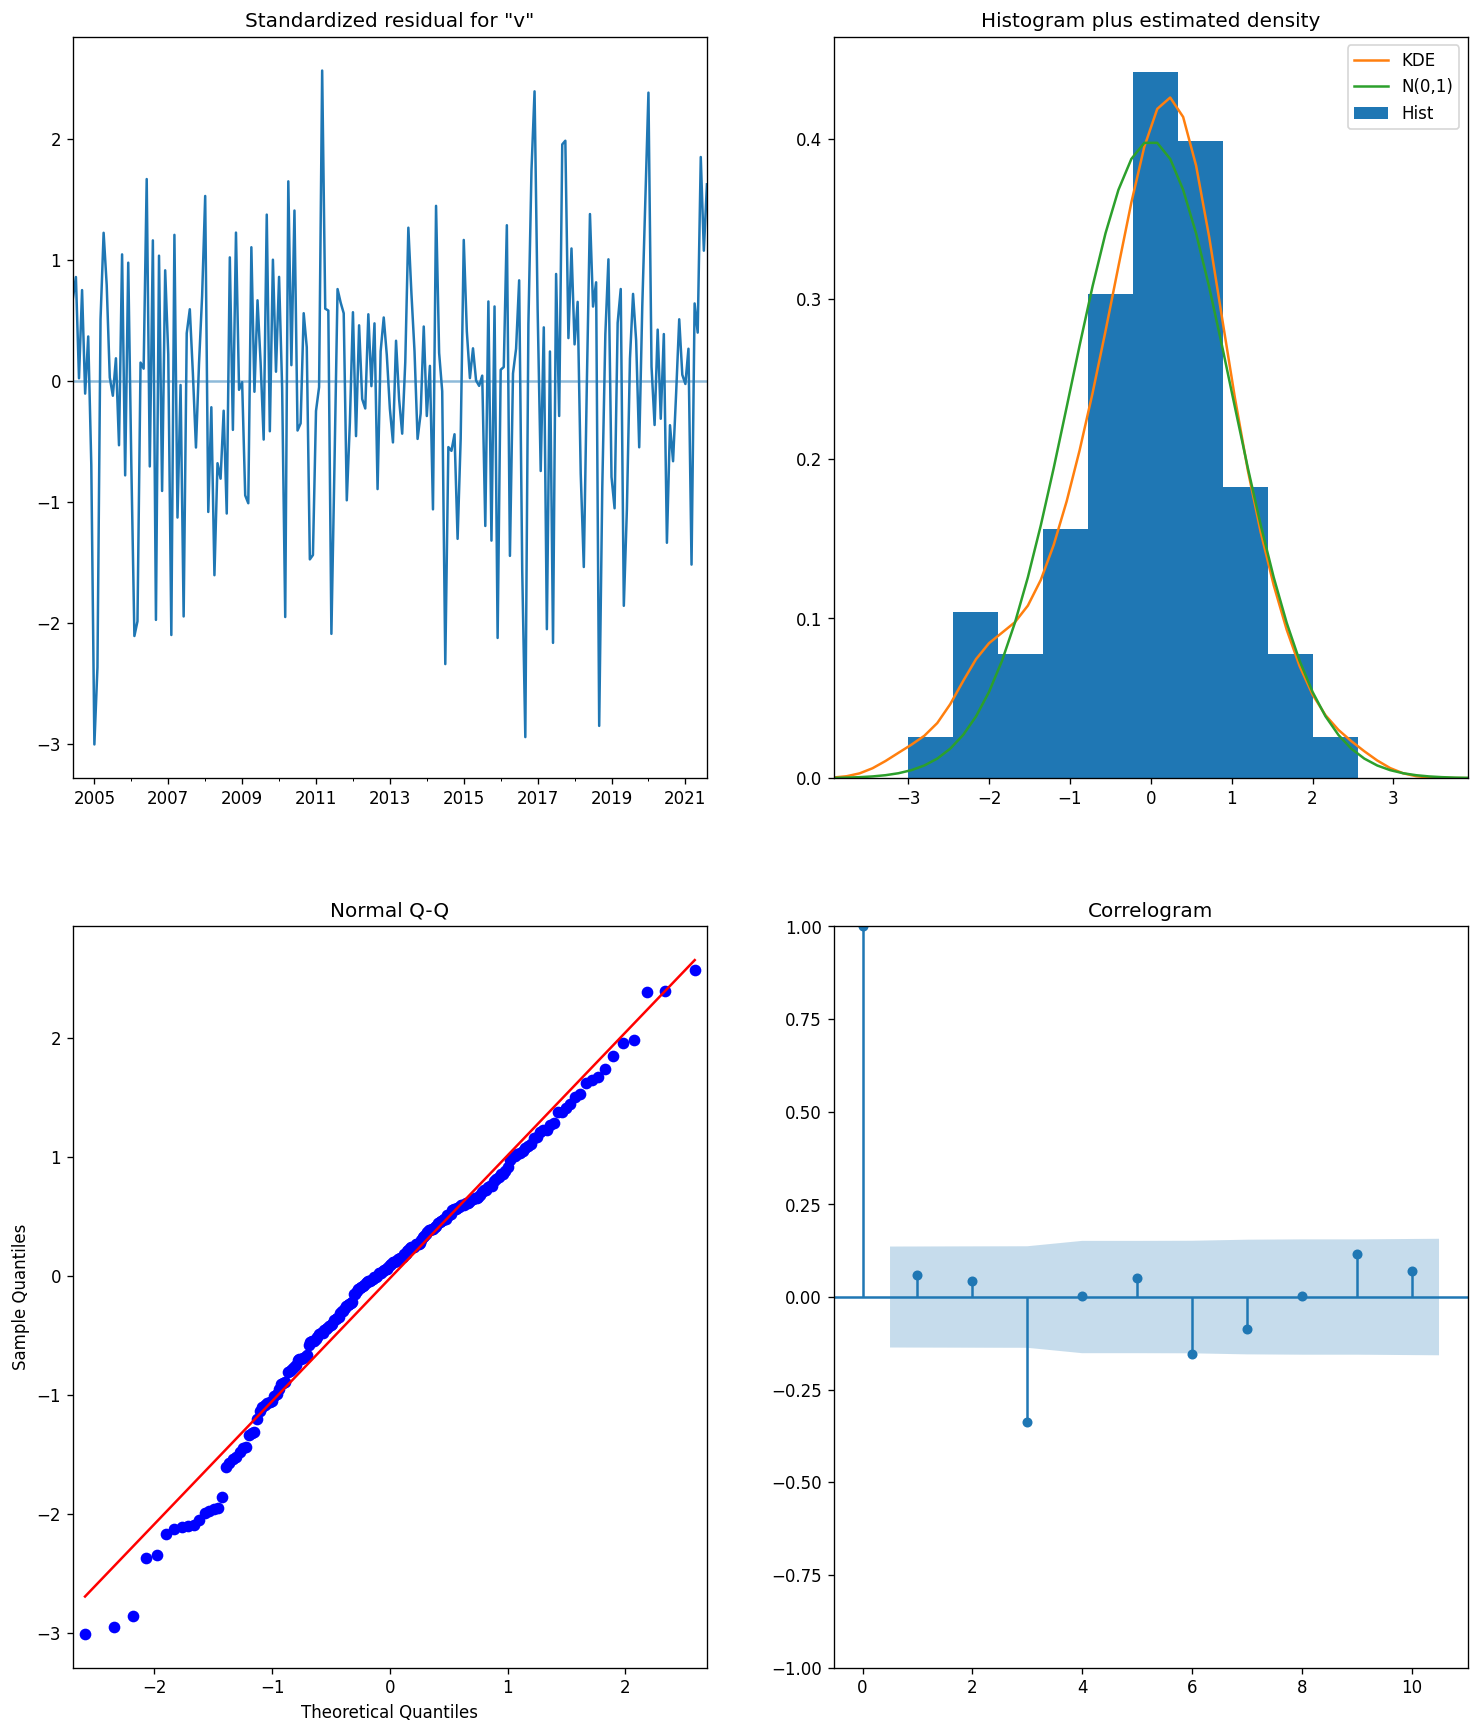

In [17]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

Top left: The residuals erros seem to fluctuate around a mean of 0 and have a uniform variance
Top Right: Suggests normal distribution with mean zero
Bottom left: Most of the dots fall on the line, with a couple of exceptions
Bottom right: The ACF plot shows the residual erros are not correlated 

## Validating the  model

The last two years will be validated starting from 2019-01-31

In [18]:
# Get predictions starting from 01-31-2019 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
pred_conf = pred.conf_int()

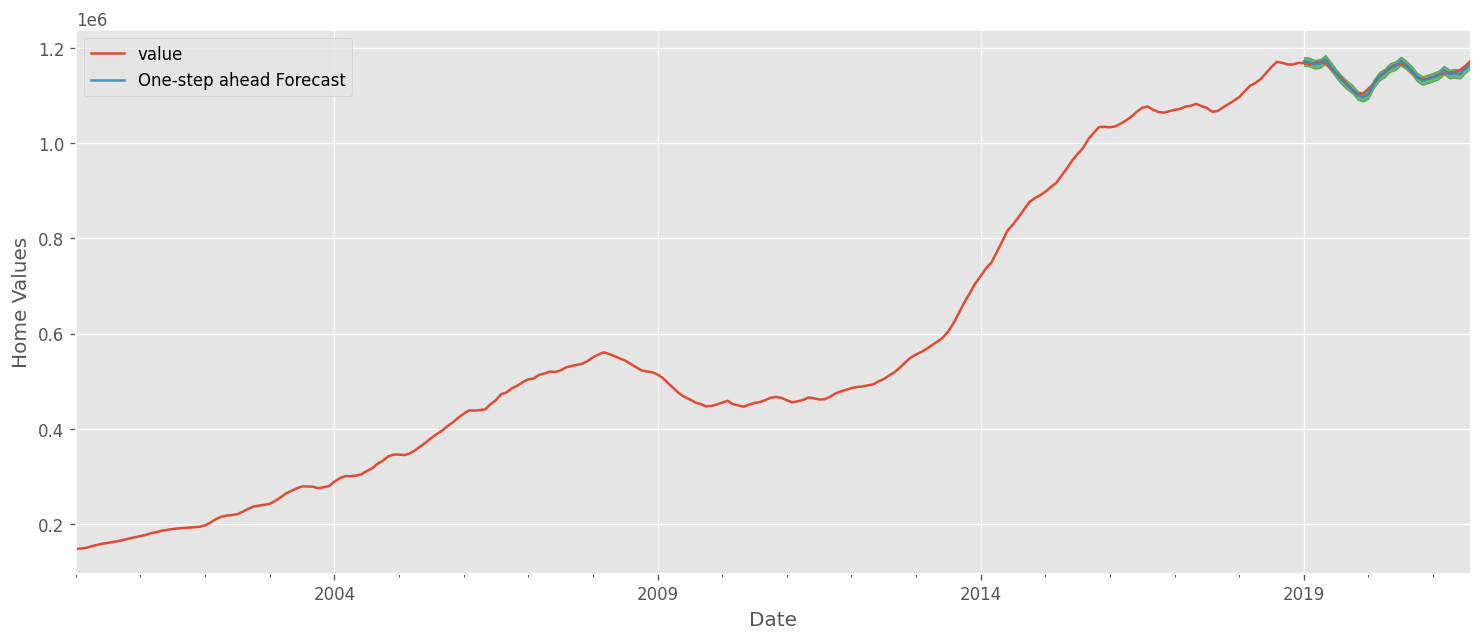

In [19]:
plt.style.use('ggplot')

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_11216.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
plt.legend()

plt.show()

The forecast aligns with the true values as seen above with the increase in trend

Now we check for the accuracy of our forecasts by using RMSE(Root Mean Square Error)

In [20]:
# Get the real and predicted values
value_forecasted = pred.predicted_mean
value_truth = df_11216['value']['2019-01-31':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 4727.47


##  Dynamic Forecasting

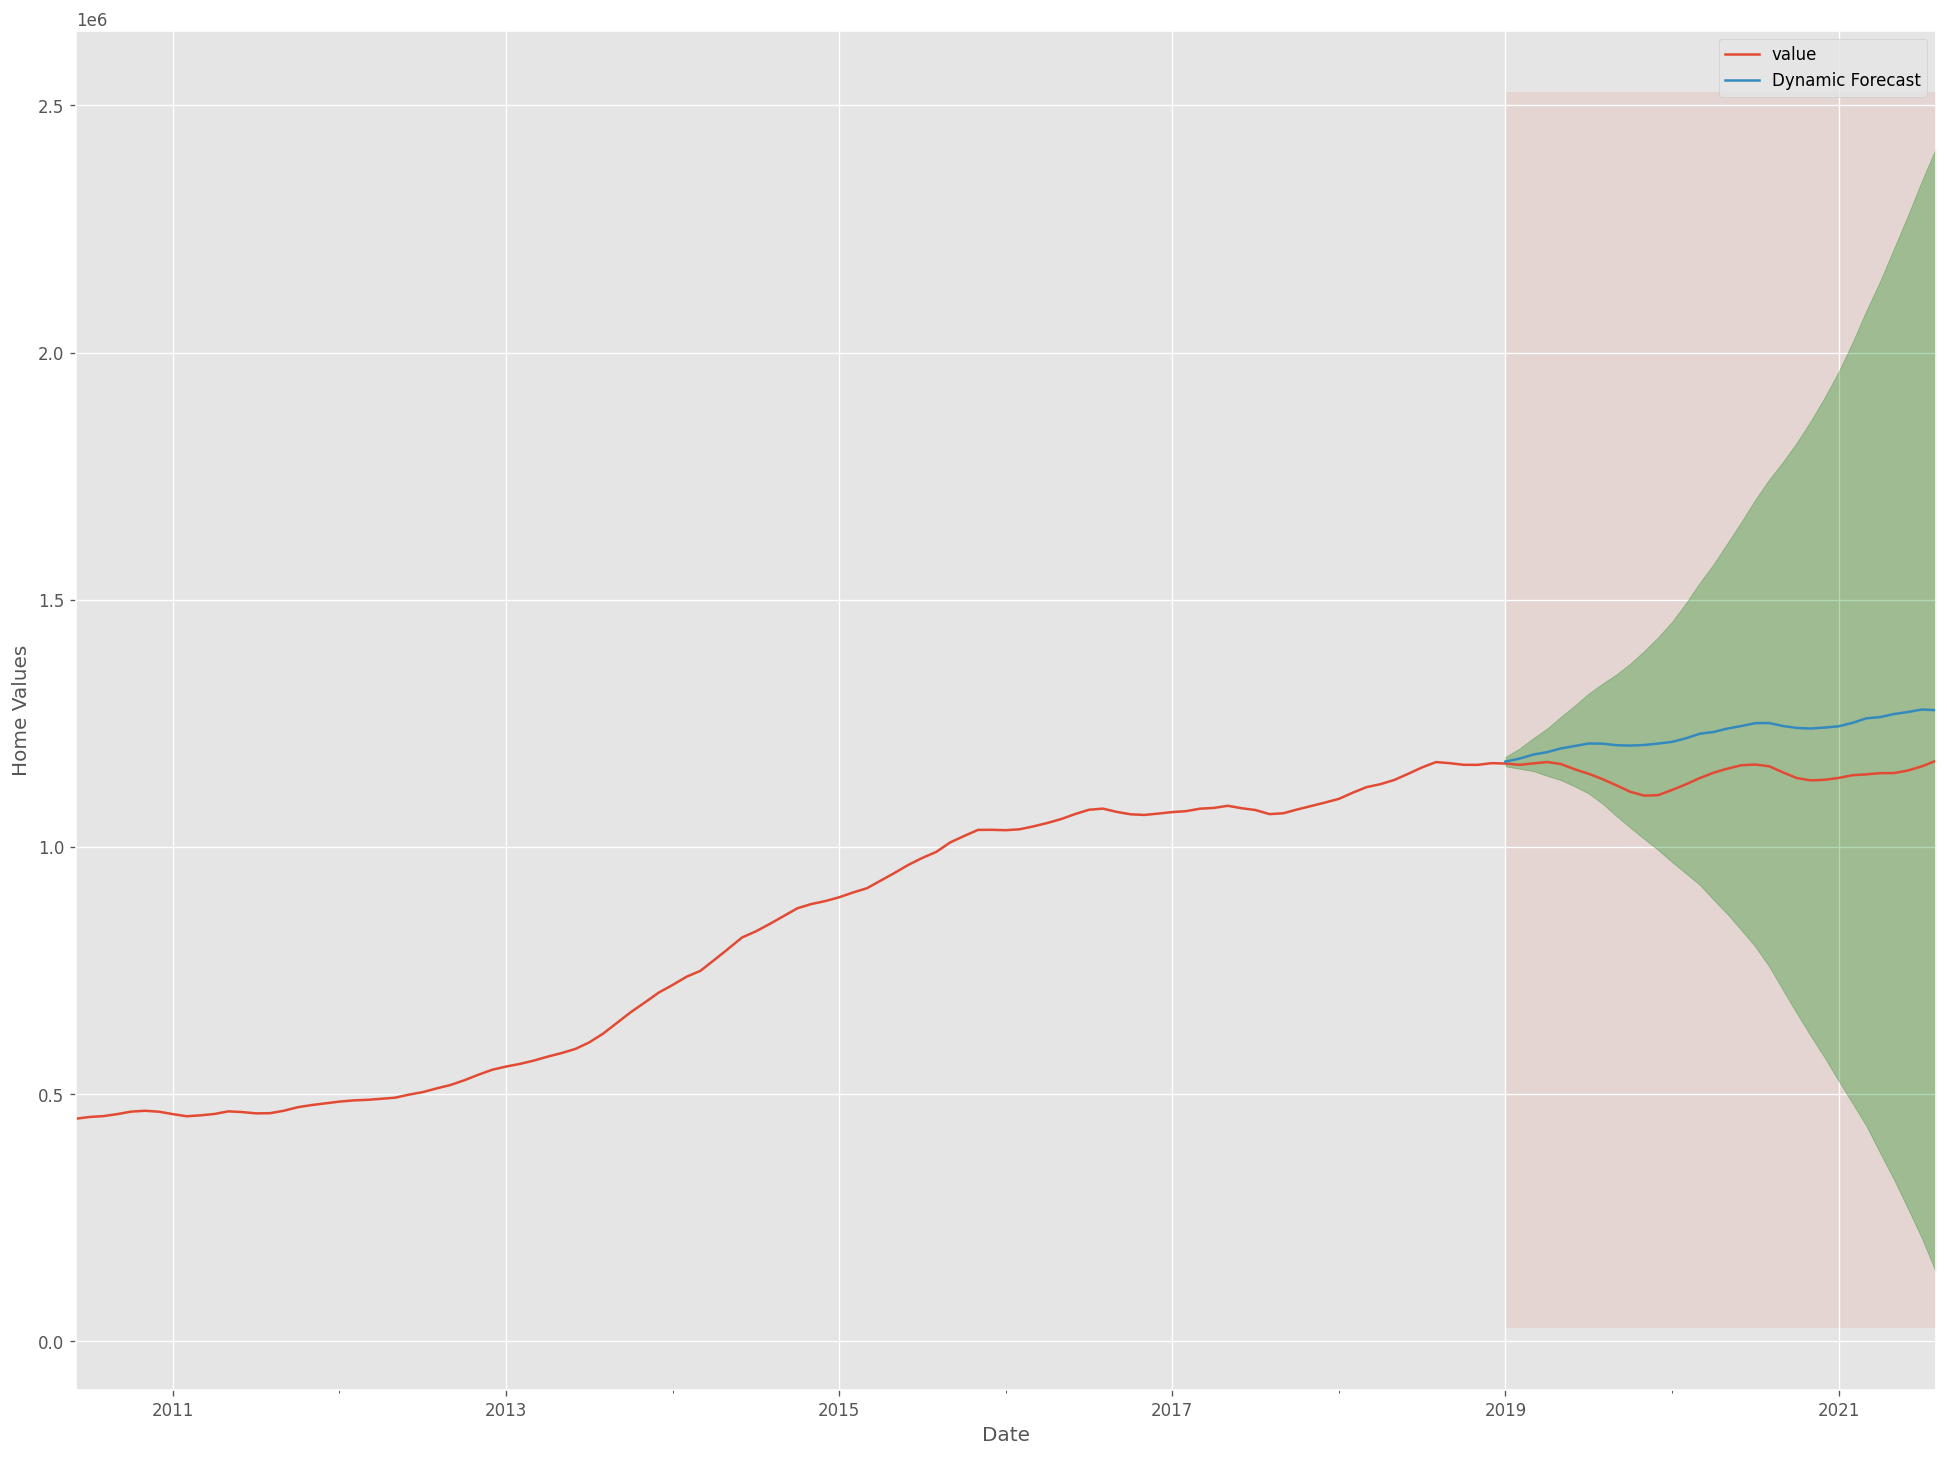

In [21]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.
ax = df_11216.iloc[125:].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-01-31'), value_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Home Values')

plt.legend()
plt.show();

In [22]:
value_forecasted = pred_dynamic.predicted_mean
value_truth = df_11216['value']['2019-01-31':]

# Compute the mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 88594.08


## Producing and Visualizing Forecasts

THe model is now used to forecast values in the future

In [23]:
# Get forecast 100 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

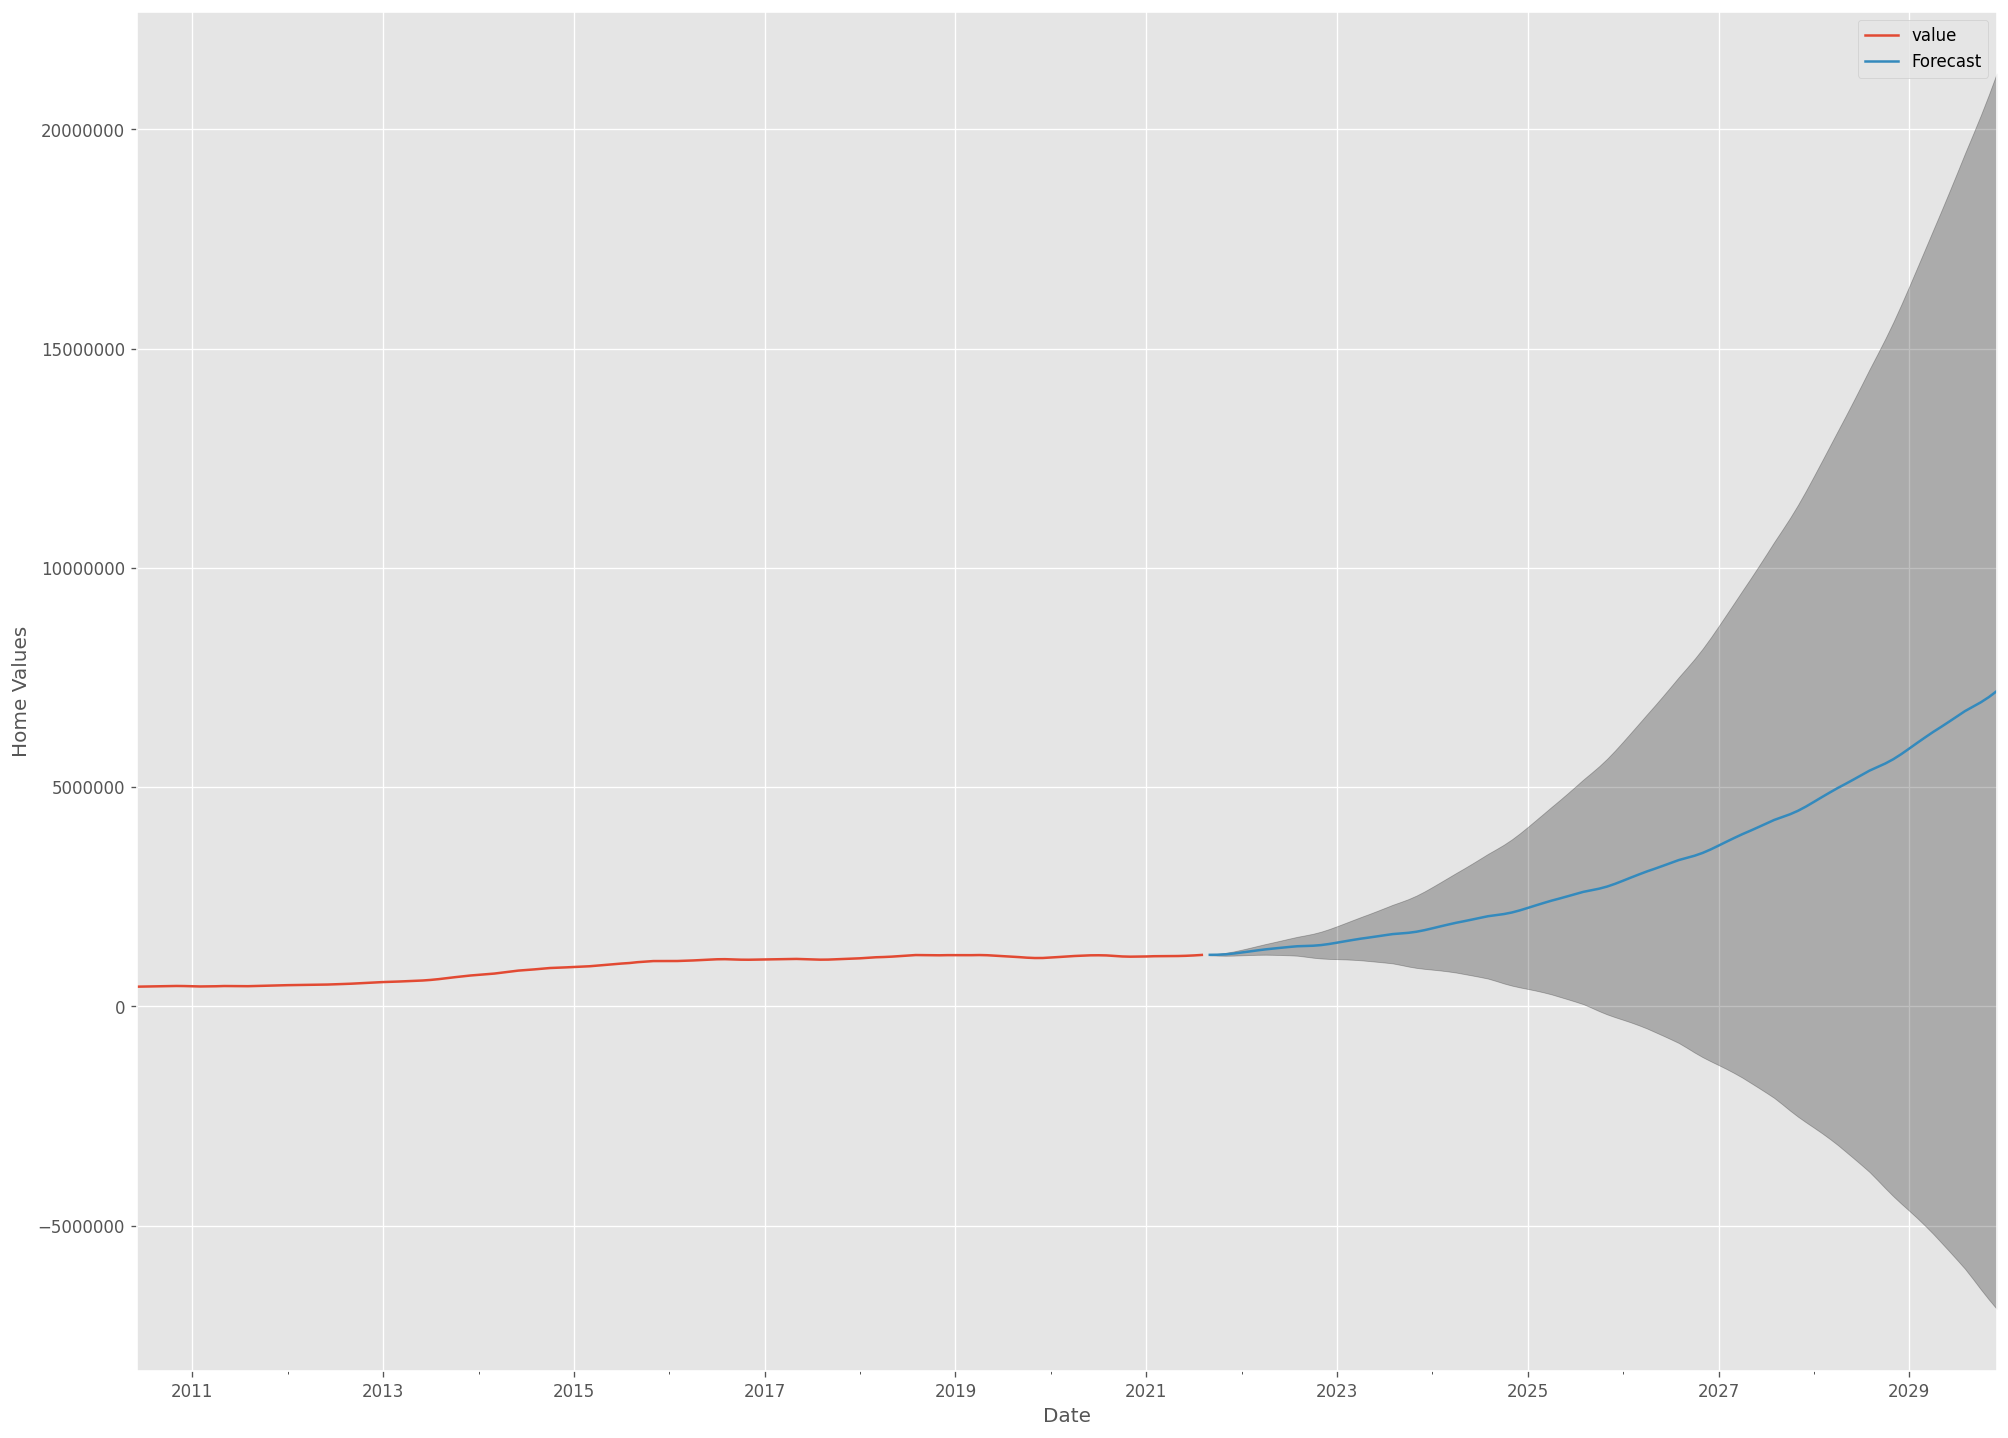

In [24]:
# Plot future predictions with confidence intervals
ax = df_11216.iloc[125:].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.legend()
plt.show();

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the dataset for zipcode 11216 and foresee what to expect. We get less confident as we go more into the future